# Inventory Optimization with Reinforcement Learning

**Done by: Sebastian Sarasti**

## Problem Statement

What is really inventory optimization?

Inventory Optimization aims to create machine learning models for forecasting the next incoming demand. The goal is to have an stronger supply chain which is not reactive to the events happened. 

Overall, you have two kind of models to create:

1. Forecasting -> To predict the future demand (Prophet, ARIMA, etc.)
2. Reordering -> To predict what we should produce in a timely combination (Linear models)

**Main Advantage**

In this notebook, we will focus on the reordering modeling. In this case, you will see how you can create a model based on reinforcement learning in just few lines of code as other popular ML Frameworks.

## Modeling

Import basic libraries

In [545]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from RLInventoryOpt.qlearning import QLearningOptimizer

Define a seed generator

In [546]:
np.random.seed(99)

Problem statement:

1. We have a warehouse which distributes "Panama hats" (actually done by Ecuador). The business owner wants to analyze how much he must produce to meet the demand of the next year.
2. The business owner have provided the historical information since 5 years ago about the consumption.
3. We have current state of the warehouse and the times needed to achieve the current supply.

### Forecasting

In [547]:
# Define the start and end dates
start_date = "2019-01-01"
end_date = "2024-12-31"

# Create a date range with a monthly frequency
date_range = pd.date_range(start=start_date, end=end_date, freq="ME")

# Generate a random demand for each date in the date range
demand = np.random.randint(low=100, high=1000, size=len(date_range))

# Create a DataFrame with the date range and demand
df = pd.DataFrame({"date": date_range, "demand": demand})

Let's explore the fake data

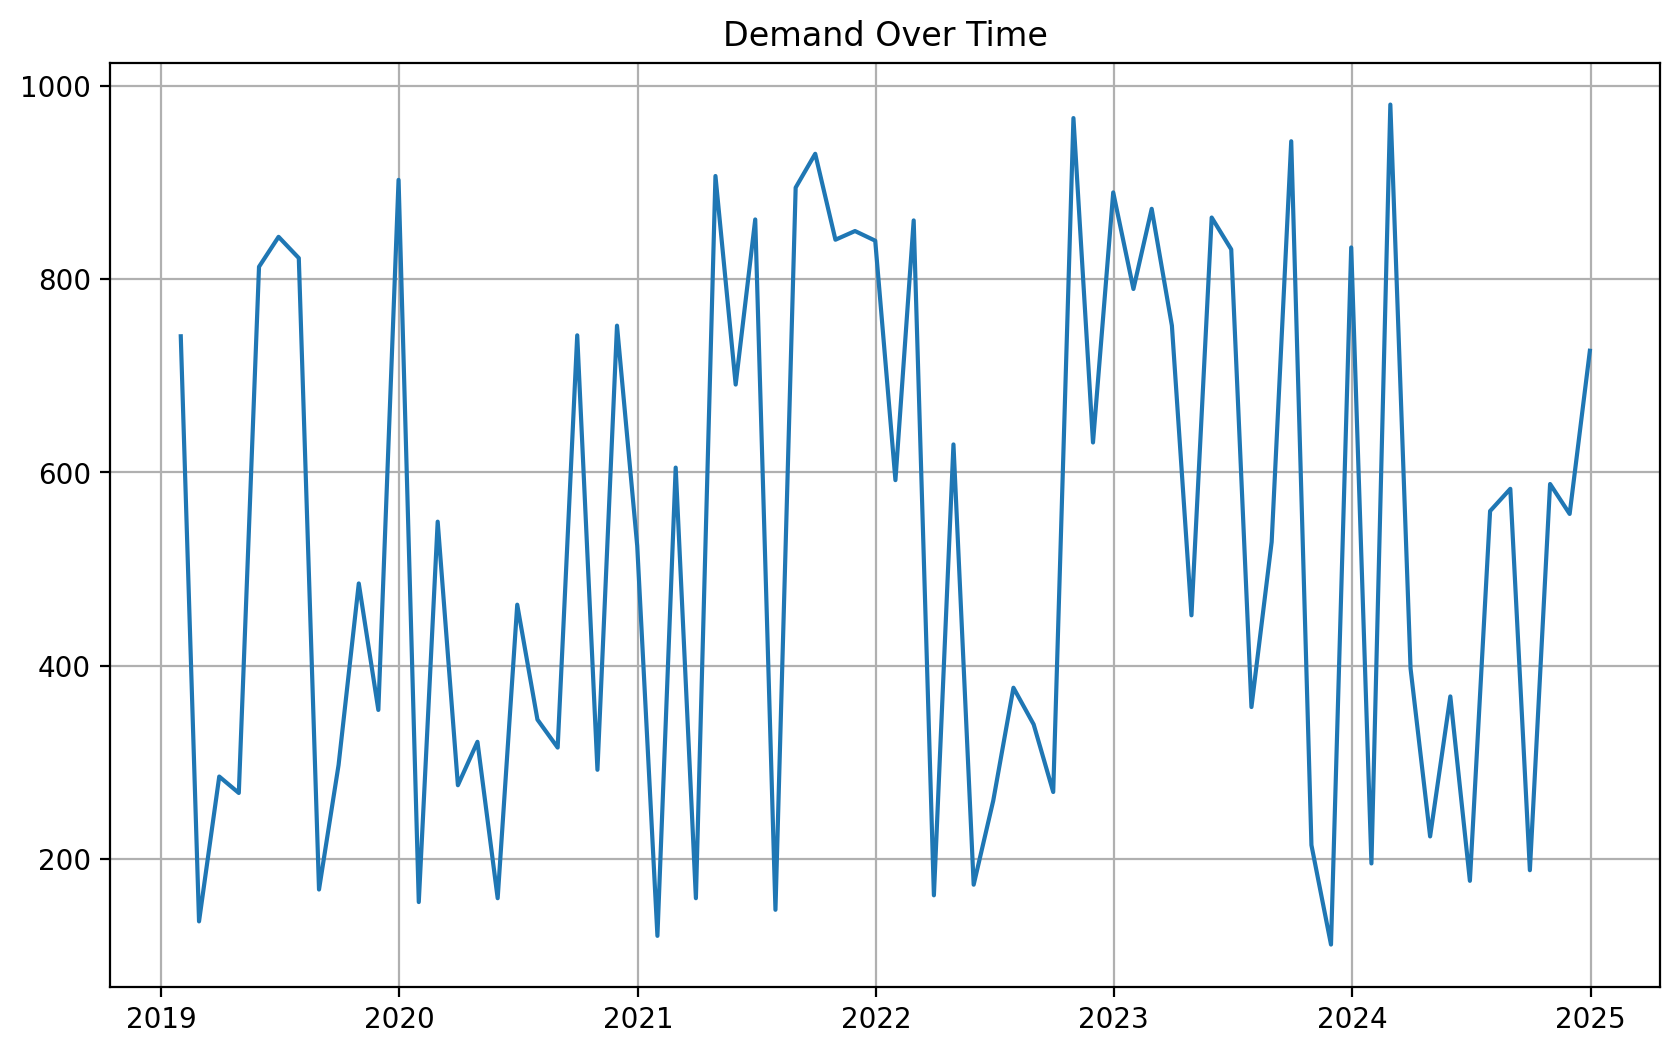

In [548]:
plt.figure(figsize=(10, 6), dpi=200)
plt.title("Demand Over Time")
plt.plot(df["date"], df["demand"])
plt.grid()
plt.show()

In [549]:
from prophet import Prophet

In [550]:
df = df.rename(columns={"date": "ds", "demand": "y"})

In [551]:
model1 = Prophet()
model1.fit(df)

09:31:15 - cmdstanpy - INFO - Chain [1] start processing
09:31:15 - cmdstanpy - INFO - Chain [1] done processing


Make a prediction for the next year

In [552]:
n_months = 12
future = model1.make_future_dataframe(periods=n_months, freq="M")
forecast = model1.predict(future)[["ds", "yhat"]].tail(n_months)

/opt/anaconda3/envs/conf/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



See the forecast and the historical data

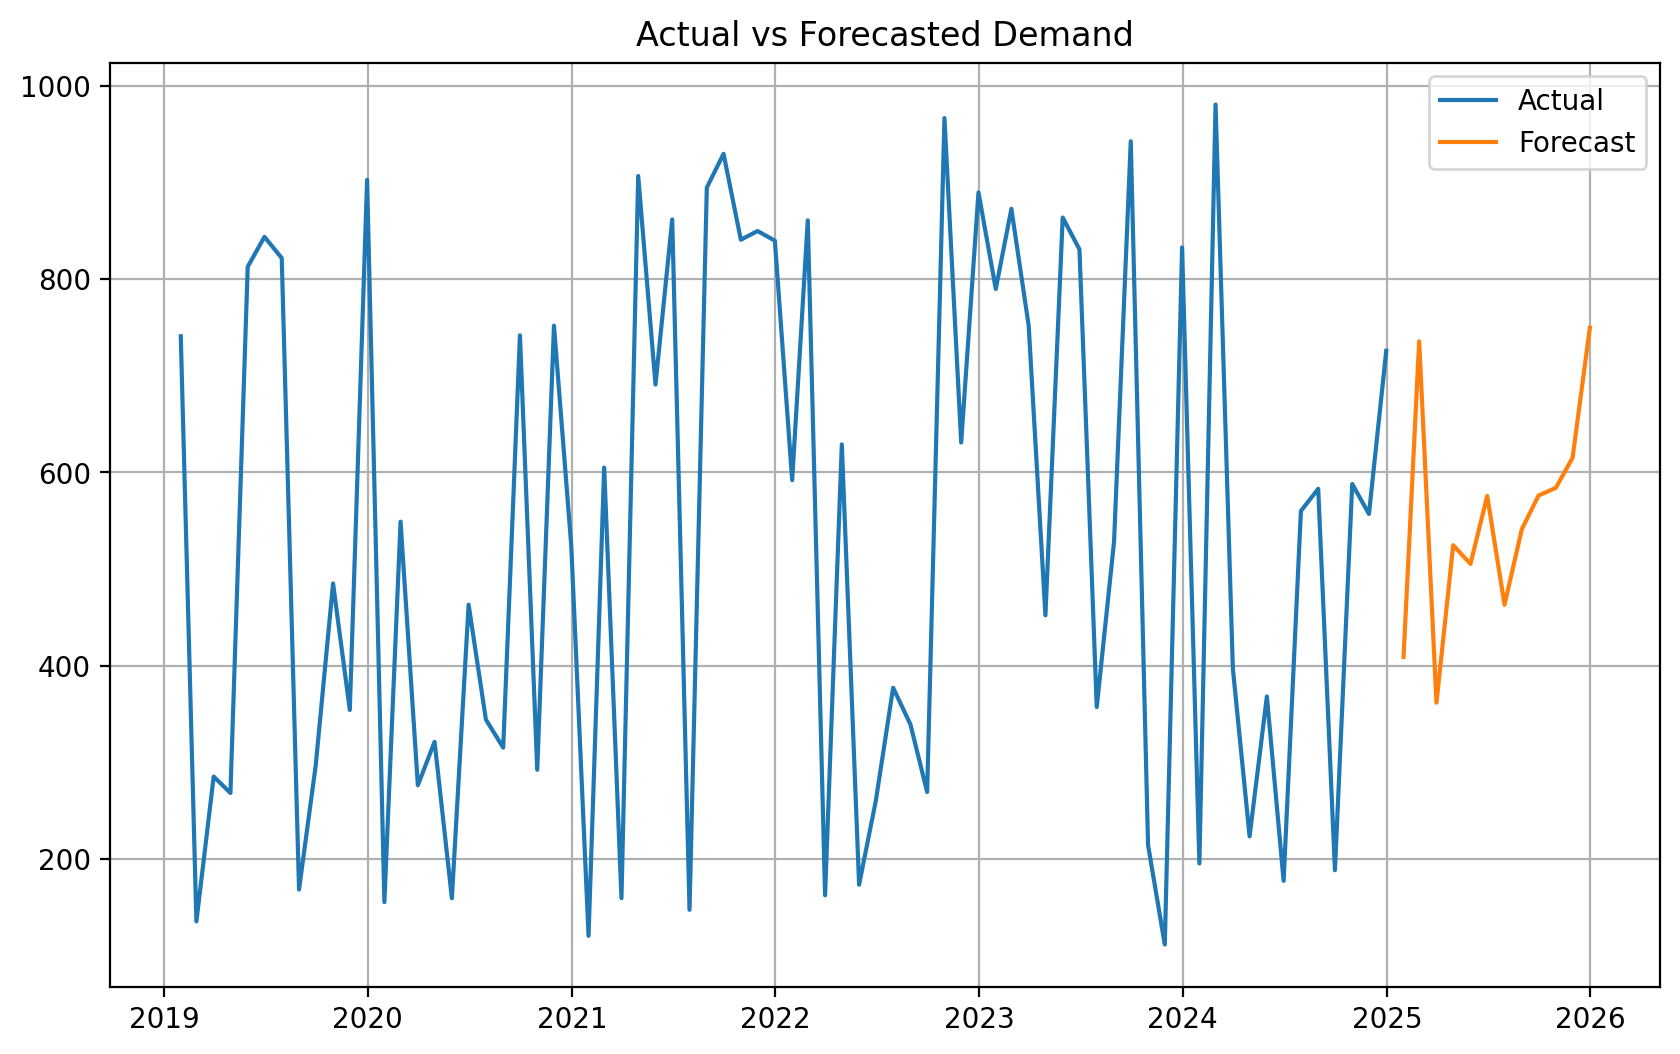

In [553]:
plt.figure(figsize=(10, 6), dpi=200)
plt.plot(df["ds"], df["y"], label="Actual")
plt.plot(forecast["ds"], forecast["yhat"], label="Forecast")
plt.grid()
plt.legend()
plt.title("Actual vs Forecasted Demand")
plt.show()

## Inventory Optimization

Well, but, what are the conditions to iterate over the inventory?

1. **Initial stock:** how many items do we have available for the time $t$.
2. **Lead-time:** the time required to arrive new units.
3. **Minimum Order:** the minimum amount of items to ask to our providers. Sometimes, we need to ask above a defined units because of contract definitions.
4. **Maximum Capacity:** this is the physical constrain of the warehouse. You cannot have more items because you have no space.

In [554]:
initial_state = {
    "stock": 1500,
    "leadTime": 2,
    "minimumOrder": 20,
    "securityStock": 100,
    "maximalCapacity": 3000,
}

In addition to the previous conditions, we need to define the actions that our agent can do:

In [555]:
actions = [
    "no",
    "m",
    "2m",
    "5m",
    "9m",
    "15m",
    "20m",
    "30m",
    "40m",
    "50m",
    "80m",
    "70m",
    "100m",
]

Define the model

In [556]:
model = QLearningOptimizer(
    forecast=np.round(forecast["yhat"].values, 0),
    initial_stock=initial_state["stock"],
    security_stock=initial_state["securityStock"],
    capacity=initial_state["maximalCapacity"],
    n_actions=actions,
    min_order=initial_state["minimumOrder"],
    lead_time=initial_state["leadTime"],
    alpha=0.9,
    gamma=0.7,
    epsilon=0.5,
)

Train the model

In [557]:
model.fit(epochs=10000)

In [558]:
df_pred = pd.DataFrame(model.q_table, columns=model.raw_actions)
df_pred["actions"] = df_pred.idxmax(axis=1)

Make the predictions

In [559]:
predictions = model.predict()

In [560]:
model.plot("bar")

Finally, how it would be with a linear model?

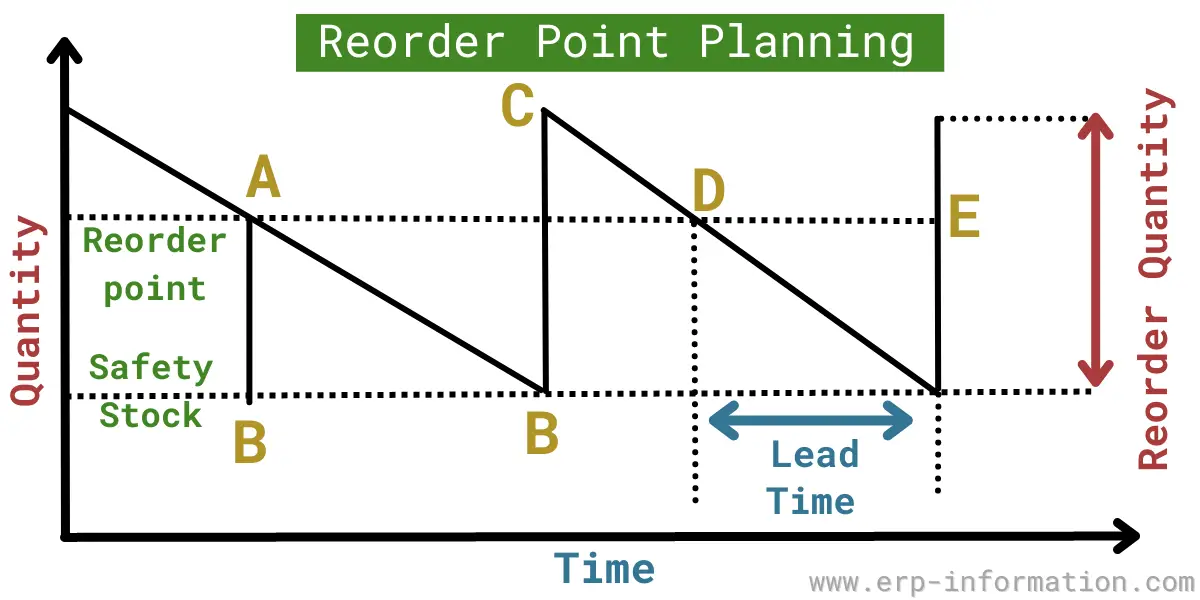